# Homework 3

In [10]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

## Problem 1 (70 points)

Consider the following quadratic problem:

$$ \underset{\boldsymbol{x_1,x_2}}{\text{min}}\quad f(x_1,x_2) \triangleq 2x_{1}^{2}+3x_{2}^{2}-2x_1x_2 -6x_1 - 12x_2 \tag{1} $$

### (a)

Let $\mathbf{x} = (x_1, x_2)^\top$. Then find $\mathbf{A}\in \mathbb{R}^{2\times2}$ and $\mathbf{b}\in \mathbb{R}^{2}$ such that the problem can be restated as follows

$$ \underset{\mathbf{x}}{\text{min}}\quad f(\mathbf{x}) \triangleq \frac{1}{2} \mathbf{x}^\top \mathbf{A} \mathbf{x} - \mathbf{b}^\top\mathbf{x} \tag{2} $$

### Answer:

$$\mathbf{A}=\left(\begin{array}{cc}4 & -2 \\ -2 & 6\end{array}\right)$$

$$\mathbf{b}=\left(\begin{array}{c}6 \\ 12\end{array}\right)$$

### (b)

Use the Gradient Descent method to solve problem $(2)$ for the following choices of the step size parameter:

1.  Constant step size $t^k=0.1$;
    
2.  Exact line search;
    
3.  Backtracking line search ($\alpha = 0.2$, $\beta = 0.8$).
    

Choose $\mathbf{x}^0=(0, 0)$ as the initial point.

In [11]:
# Parameters
A = np.array([[4, -2],
              [-2, 6]])
b = np.array([6, 12])
x0 = np.array([0, 0])       # Initial point
epsilon = 1e-6              # Convergence tolerance

# Objective function
def f(x):
    global A, b
    return 0.5 * x.T @ A @ x - b.T @ x

# Gradient
def grad_f(x):
    global A, b
    return A @ x - b

# Gradient descent with constant stepsize
def constant_stepsize(x):
    global A, b, epsilon
    x_list = [x]
    f_list = []

    for _ in range(1000):
        grad = grad_f(x)

        # Stepsize
        t = 0.1

        # Update
        x = x - t * grad
        x_list.append(x)
        f_list.append(f(x))

        # Check convergence
        if np.linalg.norm(grad) <= epsilon:
            break

    return x, x_list, f_list, np.linalg.norm(grad)

# Gradient descent with Exact Line Search
def exact_line_search(x):
    global A, b, epsilon
    x_list = [x]
    f_list = []

    for _ in range(1000):
        grad = grad_f(x)
        
        # Stepsize
        t = np.linalg.norm(grad) ** 2 / (grad.T @ A @ grad)

        # Update
        x = x - t * grad
        x_list.append(x)
        f_list.append(f(x))

        # Check convergence
        if np.linalg.norm(grad) <= epsilon:
            break

    return x, x_list, f_list, np.linalg.norm(grad)

# Gradient descent with Backtracking Line Search
def backtracking_line_search(x):
    global A, b, epsilon
    x_list = [x]
    f_list = []
    alpha = 0.2
    beta = 0.8

    for _ in range(1000):
        grad = grad_f(x)
        
        # Stepsize
        t = 1
        while f(x - t * grad) > f(x) - alpha * t * np.linalg.norm(grad) ** 2:
            t = beta * t

        # Update
        x = x - t * grad
        x_list.append(x)
        f_list.append(f(x))

        # Check convergence
        if np.linalg.norm(grad) <= epsilon:
            break

    return x, x_list, f_list, np.linalg.norm(grad)

# Answers
x, x_list_cs, f_list_cs, grad = constant_stepsize(x0)
print(f"Gradient Descent with constant stepsize: x = {x}, iter = {len(f_list_cs)}, grad = {grad}")

x, x_list_els, f_list_els, grad = exact_line_search(x0)
print(f"Gradient Descent with exact line search: x = {x}, iter = {len(f_list_els)}, grad = {grad}")

x, x_list_bls, f_list_bls, grad = backtracking_line_search(x0)
print(f"Gradient Descent with backtracking line search: x = {x}, iter = {len(f_list_bls)}, grad = {grad}")

Gradient Descent with constant stepsize: x = [2.99999983 2.99999989], iter = 52, grad = 7.798698187846045e-07
Gradient Descent with exact line search: x = [2.99999995 2.99999995], iter = 20, grad = 6.656485674781592e-07
Gradient Descent with backtracking line search: x = [2.99999997 3.00000004], iter = 27, grad = 6.815766586808902e-07


### (c)

Use the Newton’s method to solve problem $(2)$ with a constant step size $t^k=1$ (with the same initial point).

In [12]:
# Newton's method
def newton_method(x):
    global A, b, epsilon
    x_list = [x]
    f_list = []

    for _ in range(1000):
        grad = grad_f(x)

        # Stepsize
        t = 1
        hessian = A

        # Update
        x = x - t * np.linalg.inv(hessian) @ grad
        x_list.append(x)
        f_list.append(f(x))

        # Check convergence
        if np.linalg.norm(grad) <= epsilon:
            break

    return x, x_list, f_list, np.linalg.norm(grad)

# Answer
x, x_list_nm, f_list_nm, grad = newton_method(x0)
print(f"Newton's method: x = {x}, iter = {len(f_list_nm)}, grad = {grad}")

Newton's method: x = [3. 3.], iter = 2, grad = 3.66205343881779e-15


### (d)

The [Conjugate Gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method) method is an acceleration method based on conjugate descent directions (denoted with $\mathbf{p}^k$ in the following algorithm). This method uses an adaptive step-size $t^k$ for the updates via the following formulation:

**Conjugate Gradient Algorithm**:

* * *

_Initialization_:

1.  Choose $\mathbf{x}^0$ and $\epsilon\ll 1$, and let $k=0$.

2.  Let $\mathbf{p}^0 =\mathbf{r}^0= \mathbf{b} - \mathbf{A}\mathbf{x}^0$

_Repeat_:

1.  Let $t^iter = \dfrac{\langle\mathbf{r}^k, \mathbf{r}^k\rangle}{ \langle\mathbf{p}^k, \mathbf{A}\mathbf{p}^k\rangle }$

2.  Update $\mathbf{x}^{k+1} = \mathbf{x}^{k} + t^k \mathbf{p}^k$

3.  Update $\mathbf{r}^{k+1} = \mathbf{r}^{k} - t^k \mathbf{A} \mathbf{p}^k$

4.  If $\|\mathbf{r}^{k+1}\| < \epsilon$ exit the loop

5.  Let $\gamma^iter = \dfrac{\langle\mathbf{r}^{k+1}, \mathbf{r}^{k+1}\rangle}{ \langle\mathbf{r}^k, \mathbf{r}^k\rangle }$

6.  Update $\mathbf{p}^{k+1} = \mathbf{r}^{k+1} + \gamma^k \mathbf{p}^k$

7.  Update $k=k+1$

_Return_ $\mathbf{x}^{k+1}$.

* * *

Use the Conjugate Gradient method to solve problem $(2)$ starting from $\mathbf{x}^0 = (0,0)^\top$.

In [13]:
# Conjugate Gradient
def conjugate_gradient(x):
    global A, b, epsilon
    x_list = [x]
    f_list = []

    # Initialization
    p = b - A @ x
    r = p

    for _ in range(1000):
        Ap = A @ p
        alpha = (r.T @ r) / (p.T @ Ap)

        # Update
        x = x + alpha * p
        x_list.append(x)
        f_list.append(f(x))
        r_next = r - alpha * Ap     

        # Check convergence
        if np.linalg.norm(r_next) < epsilon:
            break

        # Update
        beta = (r_next.T @ r_next) / (r.T @ r)
        p = r_next + beta * p
        r = r_next

    return x, x_list, f_list, np.linalg.norm(grad)


# Answer
x, x_list_cg, f_list_cg, grad = conjugate_gradient(x0)
print(f"Conjugate Gradient method: x = {x}, iter = {len(f_list_cg)}, grad = {grad}")

Conjugate Gradient method: x = [3. 3.], iter = 2, grad = 3.66205343881779e-15


### (e)

Calculate the optimal solution $\mathbf{x}^\star$ of problem $(2)$ and plot the convergence figures (the value of $f(\mathbf{x}^k) - f(\mathbf{x}^\star)$ vs. the iteration number $k$) for all of the algorithms in $(a)$-$(d)$. Which algorithm has the fastest rate of convergence and why?

Optimal solution: x* = [3. 3.]


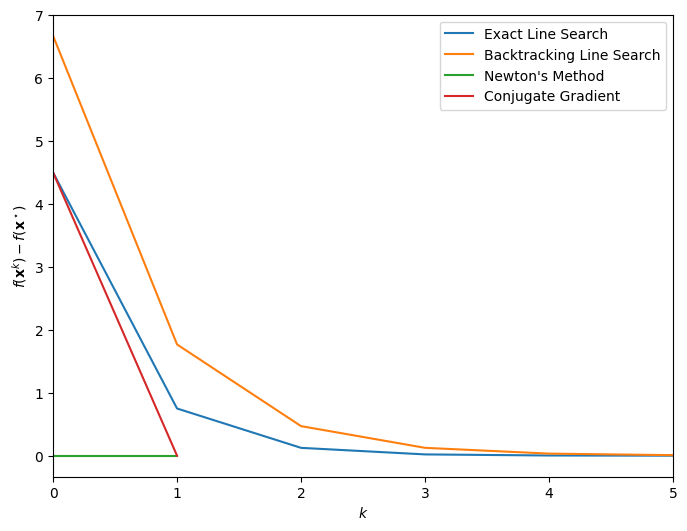

In [14]:
# Optimal solution
x = cp.Variable(2)
problem = cp.Problem(cp.Minimize(0.5 * cp.quad_form(x, A) - b.T @ x))
problem.solve()
x_opt = x.value
print(f"Optimal solution: x* = {x_opt}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(np.abs(f_list_els - f(x_opt)), label="Exact Line Search")
plt.plot(np.abs(f_list_bls - f(x_opt)), label="Backtracking Line Search")
plt.plot(np.abs(f_list_nm - f(x_opt)), label="Newton's Method")
plt.plot(np.abs(f_list_cg - f(x_opt)), label="Conjugate Gradient")
plt.xlim(0, 5)

plt.xlabel('$k$')
plt.ylabel('$f(\mathbf{x}^k) - f(\mathbf{x}^\star)$')
plt.legend()
plt.show()

Newton's method is the fastest because it considers the Hessian but the others not.

### (f) (Bonus)

Plot the paths of all the algorithm in $(a)$-$(d)$. You should plot a figure like the one below showing the contours of the function $f(\mathbf{x})$ and the path of each algorithm. Use different colors and labels for readability.

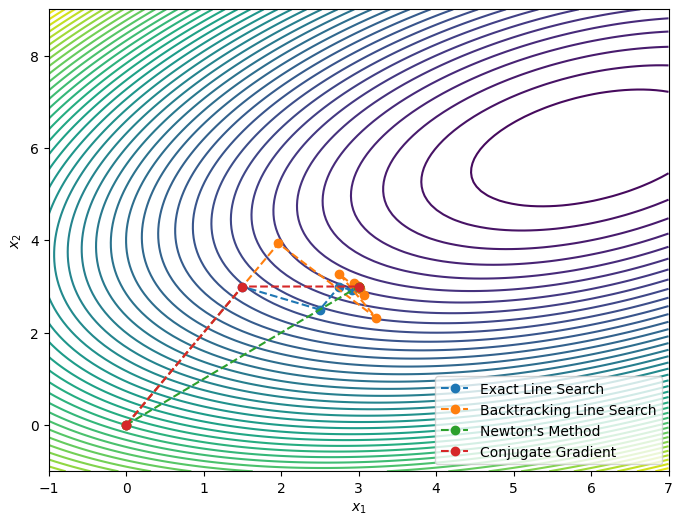

In [15]:
# Define the function f(x) for contour plot
def f_contour(x, y):
    return 0.5 * (2 * x ** 2 - 2 * x * y + 3 * y ** 2) - 6 * x - 12 * y

# Create the contour plot
x = np.linspace(-1, 7, 100)
y = np.linspace(-1, 9, 100)
X, Y = np.meshgrid(x, y)
Z = f_contour(X, Y)

plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, levels=50)
plt.plot(*zip(*x_list_els), marker='o', label="Exact Line Search", linestyle='--')
plt.plot(*zip(*x_list_bls), marker='o', label="Backtracking Line Search", linestyle='--')
plt.plot(*zip(*x_list_nm), marker='o', label="Newton's Method", linestyle='--')
plt.plot(*zip(*x_list_cg), marker='o', label="Conjugate Gradient", linestyle='--')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='lower right')
plt.show()

## Problem 2 (60 points)

As you saw in your exam, in the risk parity portfolio (RPP), you have to solve the following convex optimization problem

$$ \underset{\mathbf{x} \geq \mathbf{0}}{\mathsf{min}}~~~ g(\mathbf{x}) \triangleq\dfrac{1}{2}\mathbf{x}^\top\boldsymbol{\Sigma}\mathbf{x} - \mathbf{b}^\top\log(\mathbf{x}) \tag{3} $$

where $\log(\mathbf{x}) = (\log(x_1), \log(x_2), \dots, \log(x_N))^\top$, $\mathbf{b}$ is the risk budget vector and $\boldsymbol{\Sigma}$ is the covariance matrix of the log-returns.

In this problem we assume $N=3$ and

$$\begin{equation} \boldsymbol{\Sigma} = \begin{bmatrix} 1.0 & 0.02 & -0.04 \\ 0.02 & 1.0 & 0.02 \\ -0.04 & 0.02 & 1.0 \end{bmatrix} \end{equation}$$

$$ \mathbf{b} = \frac{\mathbf{1}}{3} $$

### (a)

Use the Jacobi algorithm to solve problem $(3)$ (derive the update formula for each element $x_i$ of $\mathbf{x}$, assuming the other elements to be constant).

_Note:_ In Jacobi algorithm, the update $\mathbf{x}^{k+1}$ in $k+1$\-th iteration is obtained after computing all $x_i^{k+1}$ updates in parallel.



### Answer:
To find update formula for $x_i$ we first take derivative of $g(\mathbf{x})$ with respect to $x_i$ (considering $x_j, j \neq i$ to be constant).

$$\frac{\partial}{\partial x_i} g(\mathbf{x})=\frac{1}{2}\left(2 \sigma_{i i} x_i+\sum_{j \neq i} 2 \sigma_{i j} x_j\right)-\frac{b_i}{x_i}$$

where $\sigma_{i j}=[\Sigma]_{i, j}$.

Now set $\frac{\partial}{\partial x_i} g(\mathbf{x})=0$.

$$\sigma_{i i} x_i^2+x_i \sum_{j \neq i} \sigma_{i j} x_j-b_i=0$$

Therefore, the closed-form solution can be obtained as:

$$x_i^{\star}=\frac{-\sum_{j \neq i} \sigma_{i j} x_j+\sqrt{\left(\sum_{j \neq i} \sigma_{i j} x_j\right)^2+4 \sigma_{i i} b_i}}{2 \sigma_{i i}}$$

In [16]:
# Parameters
Sigma = np.array([[1.0, 0.02, -0.04],
                  [0.02, 1.0, 0.02],
                  [-0.04, 0.02, 1.0]])
b = np.ones(3) / 3

# Objective function
def g(x):
    global Sigma, b
    return 0.5 * cp.quad_form(x, Sigma) - b.T @ cp.log(x)

# Jacobi algorithm
def jacobi_algorithm():
    global Sigma, b, epsilon
    g_list = []

    # Initialization
    x = np.zeros(3) / 3
    N = Sigma.shape[0]
    diag_Sigma = np.diag(Sigma)
    Sigma_off_diag = Sigma - np.eye(N)

    start_time = time.time()
    time_list = []
    
    for _ in range(1000):
        temp = 0.5* Sigma_off_diag @ x

        # Update
        x_new = (-temp + np.sqrt(temp ** 2  + 4 * diag_Sigma * b)) / (2 * diag_Sigma)
        g_list.append(g(x_new).value)
        time_list.append(time.time() - start_time)
        
        # Check convergence
        if np.linalg.norm(x_new - x) < epsilon:
            break

        # Update
        x = x_new
    
    return x_new, g_list, time_list

# Answer
x, g_list_ja, time_list_ja = jacobi_algorithm()
print(f"Jacobi algorithm: x = {x}, iter = {len(g_list_ja)}")

Jacobi algorithm: x = [0.58030293 0.5715764  0.58030293], iter = 5


### (b) (Bonus)

Find $\theta$ such that $\theta \mathbf{I} - \mathbf{\Sigma}\succeq 0$ (positive semi-definite). Then prove that $u(\mathbf{x},\mathbf{y})$ defined below, is a surrogate majorization function for $g(\mathbf{x})$. $$ u(\mathbf{x},\mathbf{y}) = \frac{1}{2}\mathbf{x}^\top\mathbf{\Sigma}\mathbf{x} + \frac{1}{2}(\mathbf{x} - \mathbf{y})^\top (\theta \mathbf{I} - \mathbf{\Sigma})(\mathbf{x} - \mathbf{y}) - \mathbf{b}^\top\log( \mathbf{x}) $$

### Answer:

$\Sigma$ is covariance matrix, so $\mathbf{\Sigma} \succeq 0$ and $\mathbf{x}^\top \Sigma \mathbf{x} \geq 0$ for any vector $\mathbf{x}$.

Suppose $\Sigma v = \lambda v$ for some eigenvalue $\lambda$ and eigenvector $v$.

$$
\begin{align*}
    \theta \mathbf{I} - \mathbf{\Sigma} &\succeq 0 \\
    \theta v^\top v - v^\top \mathbf{\Sigma} v &\succeq 0 \\
    \theta v^\top v - v^\top \lambda v &\succeq 0 \\
    \theta v^\top v - \lambda v^\top v &\succeq 0 \\
    \theta &\succeq \lambda
\end{align*}
$$

Therefore, $\theta \mathbf{I} - \mathbf{\Sigma} \succeq 0$ if $\theta \geq \lambda_{\text{max}}$.

$$
\begin{align*}
    u(\mathbf{x}, \mathbf{y}) &= \frac{1}{2} \mathbf{x}^{\top} \boldsymbol{\Sigma} \mathbf{x}+\frac{1}{2}(\mathbf{x}-\mathbf{y})^{\top}(\theta \mathbf{I}-\boldsymbol{\Sigma})(\mathbf{x}-\mathbf{y})-\mathbf{b}^{\top} \log (\mathbf{x}) \\
    g(\mathbf{x}) &= \frac{1}{2} \mathbf{x}^{\top} \mathbf{\Sigma} \mathbf{x}-\mathbf{b}^{\top} \log (\mathbf{x}) \\
    u(\mathbf{x}, \mathbf{y})-g(\mathbf{x}) &= \frac{1}{2}(\mathbf{x}-\mathbf{y})^{\top}(\theta \mathbf{I}-\mathbf{\Sigma})(\mathbf{x}-\mathbf{y})
\end{align*}
$$

Since $\theta \mathbf{I} - \mathbf{\Sigma} \succeq 0$, $\mathbf{v}^\top(\theta \mathbf{I} - \mathbf{\Sigma})\mathbf{v} \geq 0$ for any vector $\mathbf{v}$.

$$
\begin{align*}
    \frac{1}{2}(\mathbf{x}-\mathbf{y})^{\top}(\theta \mathbf{I}-\mathbf{\Sigma})(\mathbf{x}-\mathbf{y}) &\succeq 0 \\
    u(\mathbf{x}, \mathbf{y})-g(\mathbf{x}) &\succeq 0
\end{align*}
$$

Therefore, $u(\mathbf{x}, \mathbf{y}) \geq g(\mathbf{x})$ for all $\mathbf{x}$ and $\mathbf{y}$.

$$
\begin{align*}
    u(\mathbf{y}, \mathbf{y}) &= \frac{1}{2} \mathbf{y}^{\top} \mathbf{\Sigma} \mathbf{y}+\frac{1}{2}(\mathbf{y}-\mathbf{y})^{\top}(\theta \mathbf{I}-\mathbf{\Sigma})(\mathbf{y}-\mathbf{y})-\mathbf{b}^{\top} \log (\mathbf{y}) \\
    &=\frac{1}{2} \mathbf{y}^{\top} \boldsymbol{\Sigma} \mathbf{x}-\mathbf{b}^{\top} \log (\mathbf{y}) \\
    &=g(\mathbf{y})
\end{align*}
$$

Therefore, $u(\mathbf{y}, \mathbf{y}) = g(\mathbf{y})$ for all $\mathbf{y}$.

On the other hand $u(\mathbf{x}, \mathbf{y})$ is continuous and smooth $\left(C^2\right)$, therefore $\left.u^{\prime}(\mathbf{y}, \mathbf{y} ; \mathbf{d})\right|_{\mathbf{x}=\mathbf{y}}=g^{\prime}(\mathbf{y} ; \mathbf{d})$ for all $\mathbf{d}$, and $u(\mathbf{x}, \mathbf{y})$ is continuous in $\mathbf{x}, \mathbf{y}$.

By definition, $u(\mathbf{x}, \mathbf{y})$ is a surrogate majorization function for $g(\mathbf{x})$, since it satisfies all conditions.

### (c)

Use the Majorization Minimization algorithm (MM) to solve the problem via the following iterations (choose $\theta = 1.2$)

$$ \mathbf{x}^{k+1} = \underset{\mathbf{x} \geq \mathbf{0}}{\mathsf{argmin}}~~ u(\mathbf{x},\mathbf{x}^k) $$ 

_Hint:_ Rewrite $u(\mathbf{x},\mathbf{x}^k)$ as follows

$$ u(\mathbf{x},\mathbf{x}^k) = \frac{\theta}{2} \left\| \mathbf{x} - \mathbf{x} ^k + \frac{1}{\theta} \mathbf{\Sigma}\mathbf{x}^k \right\|^2 - \mathbf{b}^\top\log( \mathbf{x}) + h(\mathbf{x}^k) $$

### Answer:
$$
\begin{align*}
    u(\mathbf{x}, \mathbf{y}) &= \frac{1}{2} \mathbf{x}^{\top} \boldsymbol{\Sigma} \mathbf{x}+\frac{1}{2}(\mathbf{x}-\mathbf{y})^{\top}(\theta \mathbf{I}-\mathbf{\Sigma})(\mathbf{x}-\mathbf{y})-\mathbf{b}^{\top} \log (\mathbf{x}) \\
    &= \frac{1}{2} \mathbf{x}^{\top} \boldsymbol{\Sigma} \mathbf{x}+\frac{1}{2}\left(\theta(\mathbf{x}-\mathbf{y})^{\top}(\mathbf{x}-\mathbf{y})-\mathbf{x}^{\top} \boldsymbol{\Sigma} \mathbf{x}+\mathbf{y}^{\top} \boldsymbol{\Sigma} \mathbf{x}+\mathbf{x}^{\top} \boldsymbol{\Sigma} \mathbf{y}-\mathbf{y}^{\top} \boldsymbol{\Sigma} \mathbf{y}\right)-\mathbf{b}^{\top} \log (\mathbf{x}) \\
    &=\frac{\theta}{2}\left\|\mathbf{x}-\mathbf{y}+\frac{1}{\theta} \mathbf{\Sigma} \mathbf{y}\right\|^2-\mathbf{b}^{\top} \log (\mathbf{x})+h(\mathbf{y})
\end{align*}
$$

where

$$h(\mathbf{y})=\mathbf{y}^{\top} \mathbf{\Sigma} \mathbf{y}-\frac{1}{2 \theta}\|\mathbf{\Sigma} \mathbf{y}\|^2$$

$h\left(\mathbf{x}^k\right)$ can be discarded since it is constant in $\mathbf{x}$.

$$
\begin{align*}
    \mathbf{x}^{k+1} &= \underset{\mathbf{x} \geq \mathbf{0}}{\mathsf{argmin}}~~ u(\mathbf{x},\mathbf{x}^k) \\
    &=\underset{\mathbf{x} \geq \mathbf{0}}{\operatorname{argmin}}~~ \frac{\theta}{2}\left\|\mathbf{x}-\mathbf{x}^k+\frac{1}{\theta} \mathbf{\Sigma} \mathbf{x}^k\right\|^2-\mathbf{b}^{\top} \log (\mathbf{x})
\end{align*}
$$

Let $\mathbf{c}^k=\mathbf{x}^k-\frac{1}{\theta} \boldsymbol{\Sigma} \mathbf{x}^k$.

$$
\begin{align*}
    u\left(\mathbf{x}, \mathbf{x}^k\right) &= \frac{\theta}{2}\left\|\mathbf{x}-\mathbf{c}^k\right\|^2-\mathbf{b}^{\top} \log (\mathbf{x})+h\left(\mathbf{x}^k\right) \\
    \nabla_{\mathbf{x}} u\left(\mathbf{x}, \mathbf{x}^k\right) &= \theta\left(\mathbf{x}-\mathbf{c}^k\right)-\frac{\mathbf{b}}{\mathbf{x}}
\end{align*}
$$

Set $\nabla_{\mathbf{x}} u\left(\mathbf{x}, \mathbf{x}^k\right)=\mathbf{0}$.

$$\theta \mathbf{x}^2-\mathbf{x}\left(\theta \mathbf{c}^k\right)-\mathbf{b}=0$$

Therefore, the closed-form solution can be obtained as:

$$\mathbf{x}^{k+1}=\frac{\mathbf{c}^k+\sqrt{\left(\mathbf{c}^k\right)^2+4 \mathbf{b} / \theta}}{2}$$

In [17]:
# Majorization-Minimization algorithm
def majorization_minimization():
    global Sigma, b, epsilon
    g_list = []

    # Initialization
    theta = 1.2
    x_k = np.ones(3) / 3

    start_time = time.time()
    time_list = []
    
    for _ in range(1000):
        # Update
        c =  x_k - (Sigma @ x_k) / theta
        x_new = (c + np.sqrt(c ** 2 + 4 * b / theta)) / 2
        g_list.append(g(x_new).value)
        time_list.append(time.time() - start_time)

        # Check convergence
        if np.linalg.norm(x_new - x_k) < epsilon:
            break

        # Update
        x_k = x_new
    return x_k, g_list, time_list

# Answer
x, g_list_mm, time_list_mm = majorization_minimization()
print(f"Majorization-Minimization algorithm: x = {x}, iter = {len(g_list_mm)}")

Majorization-Minimization algorithm: x = [0.583391   0.56580045 0.583391  ], iter = 7


### (d)

Plot the convergence figures of the above methods versus time. The vertical axis should be $g(\mathbf{x}^k) - g(\mathbf{x}^\star)$ and the horizontal axis should be $t_k$ (the time taken to compute $\mathbf{x}^k$ in seconds, starting from zero at $k=0$). You may obtain $\mathbf{x}^\star$ using `cvxpy`.

Optimal solution: x* = [0.58339169 0.56580061 0.58339169]


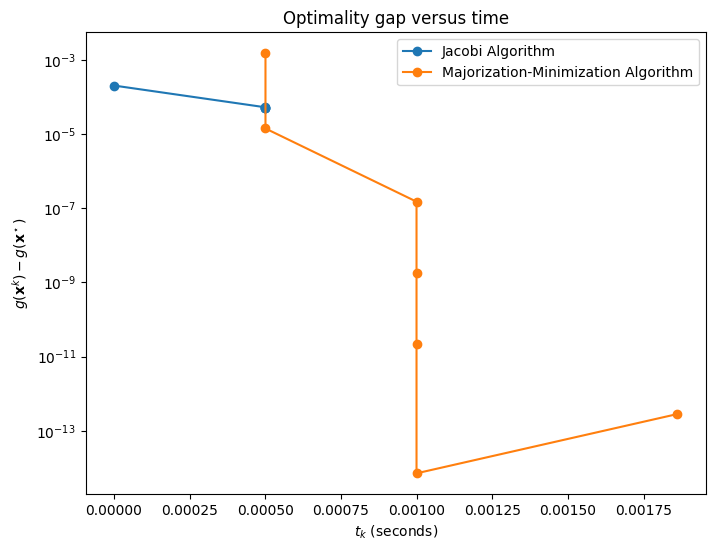

In [18]:
# Optimal solution
x = cp.Variable(3)
problem = cp.Problem(cp.Minimize(0.5 * cp.quad_form(x, Sigma) - b.T @ cp.log(x)), [x >= 0])
problem.solve()
x_opt = x.value
print(f"Optimal solution: x* = {x_opt}")

# Plot
plt.figure(figsize=(8, 6))
plt.semilogy(time_list_ja, np.abs(np.array(g_list_ja) - g(x_opt).value), marker='o', label="Jacobi Algorithm")
plt.semilogy(time_list_mm, np.abs(np.array(g_list_mm) - g(x_opt).value), marker='o', label="Majorization-Minimization Algorithm")

plt.title("Optimality gap versus time")
plt.xlabel('$t_k$ (seconds)')
plt.ylabel('$g(\mathbf{x}^k) - g(\mathbf{x}^\star)$')
plt.legend()
plt.show()